In [1]:
# Greg Maurer - August 2015

library(ggplot2)
library(plyr)
library(reshape2)

theme_set(theme_bw())

setwd('~/current/NMEG_seasonality/')

proc_path <- 'processed_data/'

source('~/current/NMEG_utils/r_functions/printfigs.r')
source('~/current/NMEG_utils/r_functions/load_nmeg.r')
source('~/current/NMEG_utils/r_functions/transform_nmeg.r')
source('load_datasets.r')

seg <- get_daily_file('Seg', make_new=FALSE)
ses <- get_daily_file('Ses')
wjs <- get_daily_file('Wjs')
mpj <- get_daily_file('Mpj')
vcp <- get_daily_file('Vcp')
vcm <- get_daily_file('Vcm')
str(seg)

Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Warning message:
In file(filename, "r", encoding = encoding): cannot open file 'load_datasets.r': No such file or directory

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


'data.frame':	2922 obs. of  17 variables:
 $ X               : Factor w/ 2923 levels "2007-01-01","2007-01-02",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ GPP_g_int       : num  0.00955 0.00886 0.00147 0.10324 0.15076 ...
 $ RECO_g_int      : num  0.492 0.695 0.566 0.451 0.204 ...
 $ FC_F_g_int      : num  0.4824 0.6863 0.5648 0.3478 0.0534 ...
 $ ET_mm_fullday_0 : num  0.473 0.303 0.332 0.557 1.004 ...
 $ P_F             : num  0.614 1.024 0 0 1.024 ...
 $ TA_F            : num  -7.74 -5.98 -7.67 -1.98 3.52 ...
 $ RH_F            : num  88.5 86.5 87.9 72.6 63.1 ...
 $ SW_IN_F         : num  119 128 145 150 150 ...
 $ RNET            : num  -45.3 -162.6 -161.9 -364.4 -360.7 ...
 $ VPD_F           : num  0.1196 0.0569 0.0476 0.1822 0.3185 ...
 $ TA_F_min        : num  -13.85 -9.67 -12.26 -11 -2.04 ...
 $ VPD_F_min       : num  0.01746 0.00661 0.00575 0.00435 0.00538 ...
 $ TA_F_max        : num  31.16 -3.26 -2.93 6.94 9.91 ...
 $ VPD_F_max       : num  4.072 0.267 0.174 0.543 0.774 ...
 $ ET_F_mm_d

In [37]:
# Drop everything from water year 2015
sitelist <- list(seg, ses, wjs, mpj, vcp, vcm)
sitenames <- c('Seg', 'Ses', 'Wjs', 'Mpj', 'Vcp', 'Vcm')
FC_daily <- get_var_allsites(sitelist, 'FC_F_g_int', sitenames, startyear=2007, endyear=2014)
GPP_daily <- get_var_allsites(sitelist, 'GPP_g_int', sitenames, startyear=2007, endyear=2014)
RE_daily <- get_var_allsites(sitelist, 'RECO_g_int', sitenames, startyear=2007, endyear=2014)
ET_daily <- get_var_allsites(sitelist, 'ET_F_mm_daytime', sitenames, startyear=2007, endyear=2014)
P_gauge_daily <- get_var_allsites(sitelist, 'P_F', sitenames, startyear=2007, endyear=2014)

#FC_daily <- subset( FC_daily, year_w < 2015)
#GPP_daily <- subset( GPP_daily, year_w < 2015)
#RE_daily <- subset( RE_daily, year_w < 2015)
#ET_daily <- subset( ET_daily, year_w < 2015)
#P_gauge_daily <- subset( P_gauge_daily, year_w < 2015)
#P_PRISM_daily <- subset( P_PRISM_daily, year_w < 2015)
tail(FC_daily)

date       Seg        Ses        Wjs       Mpj        Vcp
2917 2014-12-26 0.2998273 0.29573097 0.28076532 0.7429333  0.7442932
2918 2014-12-27 0.3426373 0.47352097 0.40692355 0.5471829 -0.6123229
2919 2014-12-28 0.2611430 0.11068927 0.30333812 0.8169662 -0.3894312
2920 2014-12-29 0.2196405 0.06020422 0.07921884 0.4052005 -0.6348179
2921 2014-12-30 0.3274998 0.07948649 0.37018654 0.7475777  0.5127860
2922 2014-12-31 0.5386973 0.51144577 0.15576352 0.8681422 -0.1639382
             Vcm
2917  0.24626812
2918  0.17409733
2919  0.17981447
2920 -0.09988218
2921  0.23056414
2922  0.39904378

In [43]:
# Function to clean up unused columns and rename variables
clean_rename <- function(df, keep=c("season", "year_w", sitenames)){
    df_c_r <- add_WY_cols(df)
    df_c_r <- subset(df_c_r, subset = (year_w > 2007 & year_w < 2015))
    #print(head(df_c_r))
    #print(tail(df_c_r))
    df_c_r <- df_c_r[, keep]
    df_c_r <- rename_vars(df_c_r)
    str(df_c_r)
    return(df_c_r)
}

## Cumulative NEE by year

* Showing as bars and lines

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0.0251 0.2501 0.3142 0.3797 0.5512 ...
 $ Shrubland       : num  -0.363 -0.331 -0.263 -0.142 -0.168 ...
 $ Juniper savannah: num  -0.459 -0.608 -0.608 -0.469 -0.353 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  -0.5471 -2.7631 -2.0039 -1.081 0.0875 ...
 $ Mixed conifer   : num  -1.32 -2.3 -1.49 -1.79 -1.31 ...


ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead
ymax not defined: adjusting position using y instead


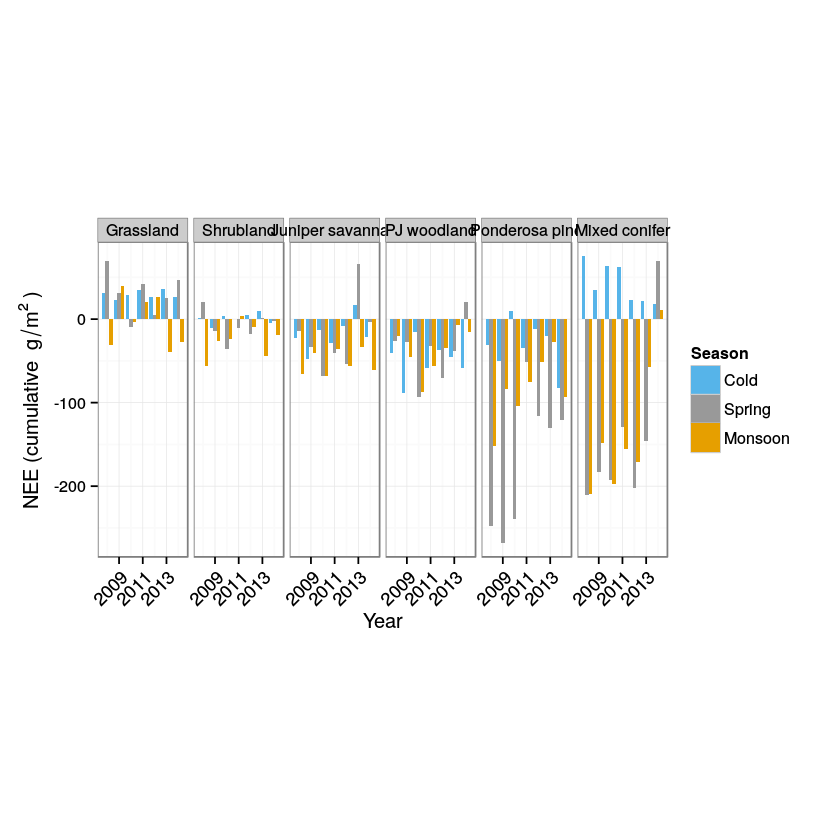

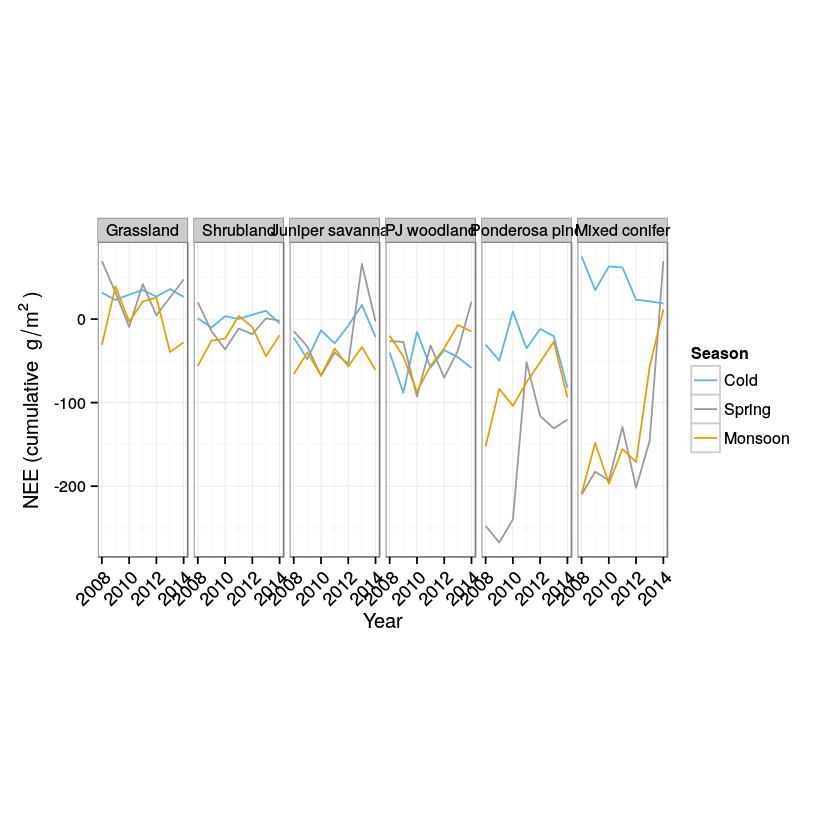

In [44]:
# Look at cumulative NEE over, divided into the 3 seasons
FC.m <- melt(clean_rename(FC_daily), id.vars=c('season', 'year_w'))
FC.m <- ddply(FC.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))

# Calculate seasonal NEE as a percentage for the year
FC.pct <- ddply(FC.m, .(variable, year_w), summarise, season=season, pct = seas_sum/sum(seas_sum, na.rm = T))


NEE_seas_by_yr <- ggplot(FC.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity', position='dodge') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

NEE_seas_by_yr

NEE_seas_by_yr2 <- ggplot(FC.m, aes(x=year_w, y=seas_sum, color=factor(season))) +
    geom_line(stat='identity', position='dodge') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('NEE (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

NEE_seas_by_yr2

In [ ]:
outpath = 'figures/'
printfigs(NEE_seas_by_yr, 'NEE_seas_by_yr.pdf', outpath, 9, 4)
printfigs(NEE_seas_by_yr2, 'NEE_seas_by_yr2.pdf', outpath, 9, 4)

## Cumulative GPP by year

* Showing as bars and lines

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0.1424 0.0887 0.086 0.1031 0.0583 ...
 $ Shrubland       : num  0.577 0.519 0.419 0.448 0.42 ...
 $ Juniper savannah: num  1.81 1.88 1.82 1.63 1.47 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  3.02 5.21 4.56 3.73 2.89 ...
 $ Mixed conifer   : num  1.91 2.88 2.09 2.47 1.8 ...


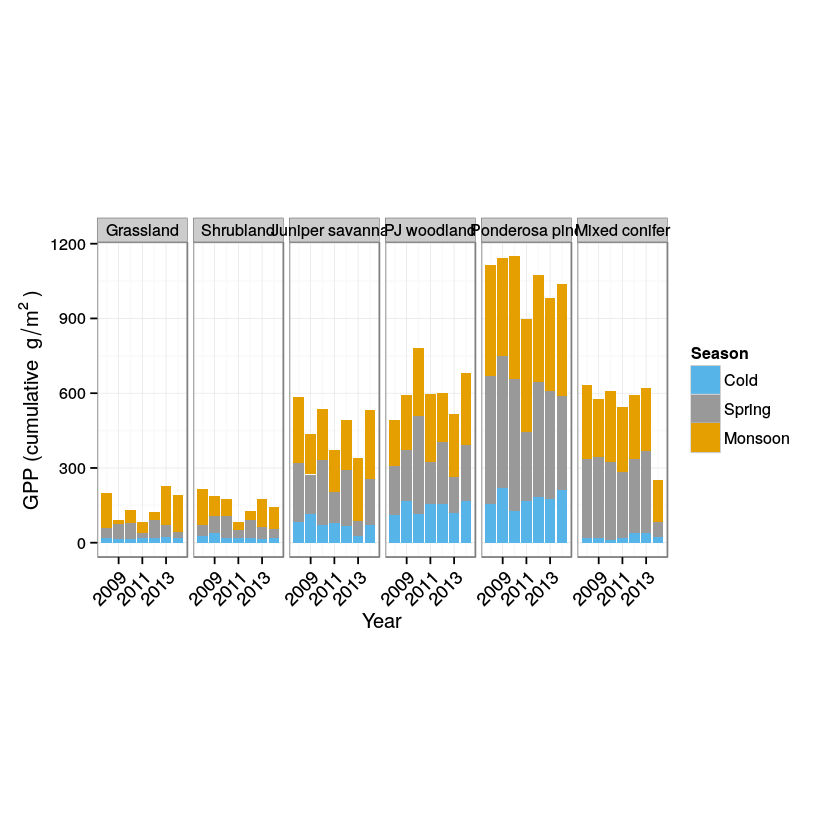

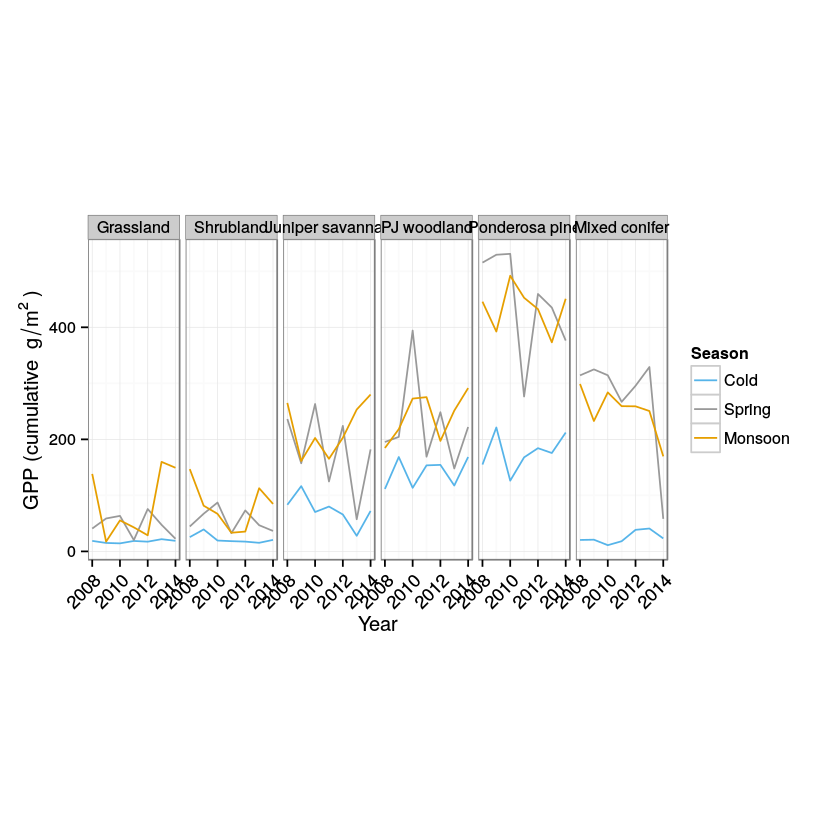

In [45]:
# Same for GPP
GPP.m <- melt(clean_rename(GPP_daily), id.vars=c('season', 'year_w'))
GPP.m <- ddply(GPP.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))

GPP_seas_by_yr <- ggplot(GPP.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
    geom_bar(stat='identity') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

GPP_seas_by_yr

GPP_seas_by_yr2 <- ggplot(GPP.m, aes(x=year_w, y=seas_sum, color=factor(season))) +
    geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

GPP_seas_by_yr2

In [ ]:
printfigs(GPP_seas_by_yr, 'GPP_seas_by_yr.pdf', outpath, 9, 4)
printfigs(GPP_seas_by_yr2, 'GPP_seas_by_yr2.pdf', outpath, 9, 4)

## Cumulative GPP as percent of total by year

    variable year_w  season        pct
1  Grassland   2008    Cold 0.09482844
2  Grassland   2008  Spring 0.20606713
3  Grassland   2008 Monsoon 0.69910443
4  Grassland   2009    Cold 0.16509042
5  Grassland   2009  Spring 0.64394548
6  Grassland   2009 Monsoon 0.19096410
7  Grassland   2010    Cold 0.10776643
8  Grassland   2010  Spring 0.47629715
9  Grassland   2010 Monsoon 0.41593641
10 Grassland   2011    Cold 0.22778775


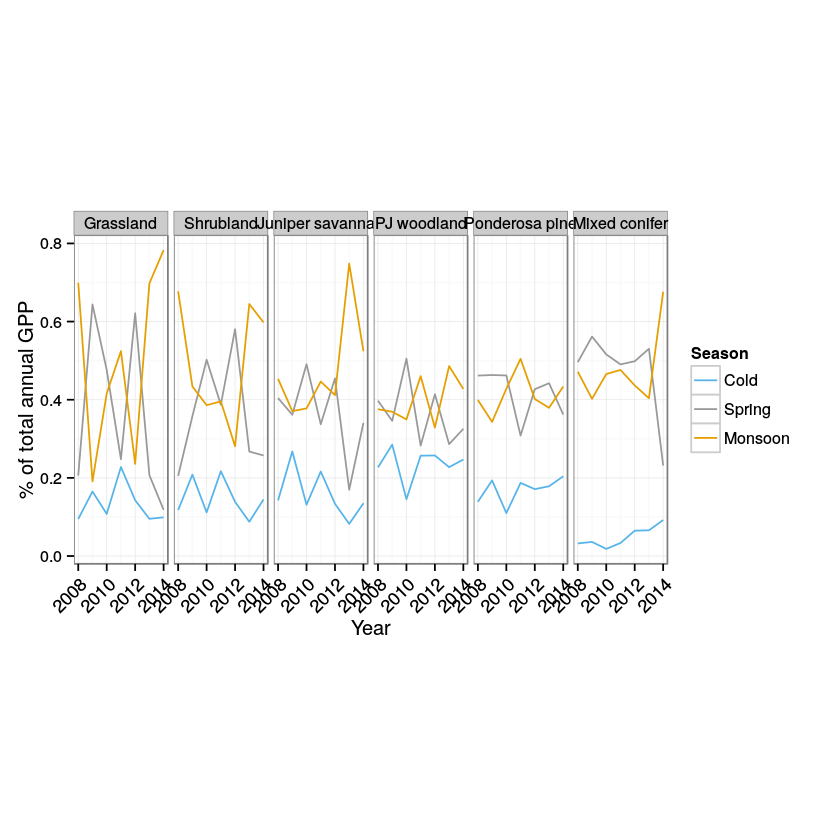

In [46]:
# Calculate seasonal GPP as a percentage for the year
GPP.pct <- ddply(GPP.m, .(variable, year_w), summarise, season=season, pct = seas_sum/sum(seas_sum, na.rm = T))
print(GPP.pct[1:10,])

GPP_seas_pct_yr <- ggplot(GPP.pct, aes(x=year_w, y=pct, color=factor(season))) +
    geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab('% of total annual GPP' ) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

GPP_seas_pct_yr

In [ ]:
printfigs(GPP_seas_pct_yr, 'GPP_seaspct_yr.pdf', outpath, 9, 4)

## Cumulative Reco by year

* Showing as bars and lines

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0.167 0.339 0.4 0.483 0.61 ...
 $ Shrubland       : num  0.214 0.188 0.156 0.306 0.252 ...
 $ Juniper savannah: num  1.35 1.27 1.21 1.16 1.12 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  2.47 2.45 2.56 2.65 2.98 ...
 $ Mixed conifer   : num  0.59 0.581 0.599 0.676 0.484 ...


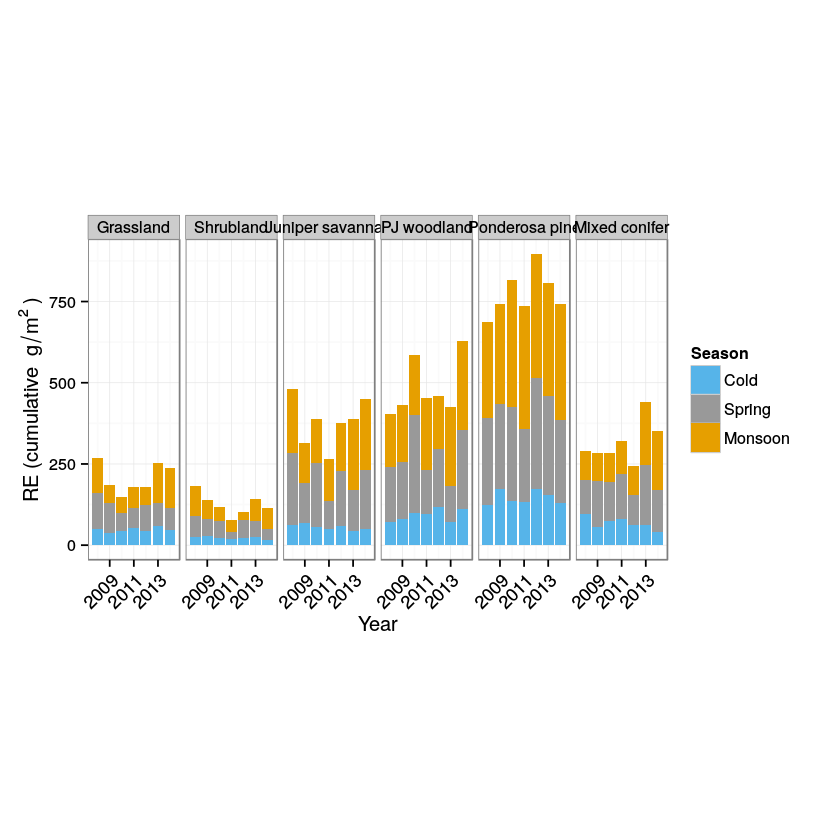

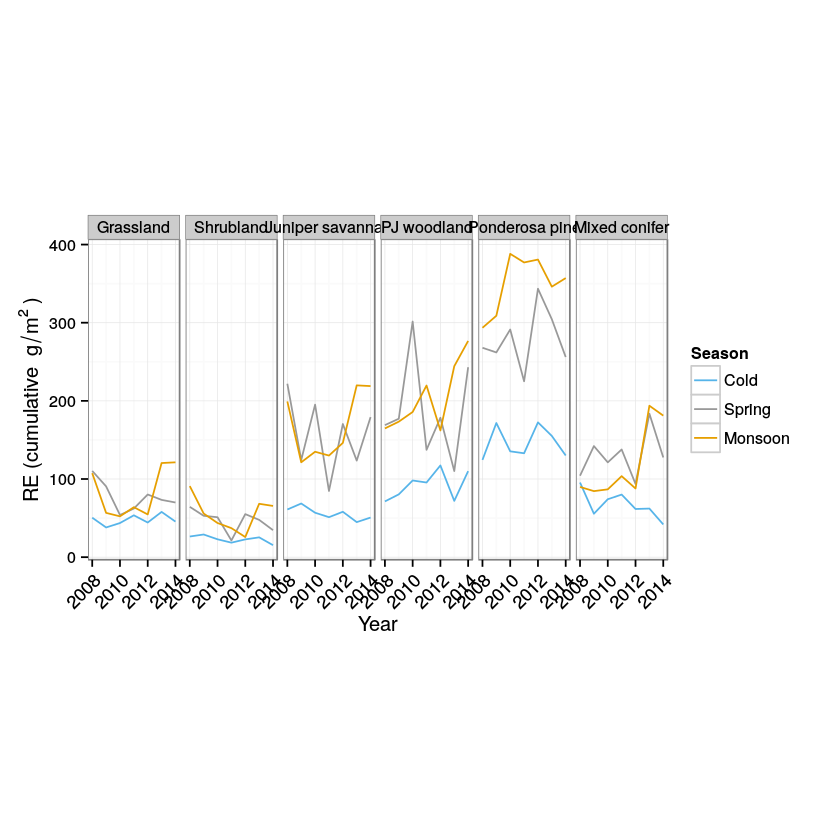

In [47]:
RE.m <- melt(clean_rename(RE_daily), id.vars=c('season', 'year_w'))
RE.m <- ddply(RE.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))

RE_seas_by_yr <- ggplot(RE.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
  geom_bar(stat='identity') + facet_wrap(~variable, nrow=1) + 
  xlab('Year') + ylab(bquote('RE (cumulative '~ g/m^2 ~')')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

RE_seas_by_yr


RE_seas_by_yr2 <- ggplot(RE.m, aes(x=year_w, y=seas_sum, color=factor(season))) +
  geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
  xlab('Year') + ylab(bquote('RE (cumulative '~ g/m^2 ~')')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

RE_seas_by_yr2

In [ ]:
printfigs(RE_seas_by_yr, 'RE_seas_by_yr.pdf', outpath, 9, 4)
printfigs(RE_seas_by_yr2, 'RE_seas_by_yr2.pdf', outpath, 9, 4)

## Cumulative Reco as percent of total by year

    variable year_w  season       pct
1  Grassland   2007    Cold 0.2002459
2  Grassland   2007  Spring 0.4545731
3  Grassland   2007 Monsoon 0.3451811
4  Grassland   2008    Cold 0.1882145
5  Grassland   2008  Spring 0.4112419
6  Grassland   2008 Monsoon 0.4005437
7  Grassland   2009    Cold 0.2051457
8  Grassland   2009  Spring 0.4889964
9  Grassland   2009 Monsoon 0.3058578
10 Grassland   2010    Cold 0.2914289


Warning message:
: Removed 3 rows containing missing values (geom_path).

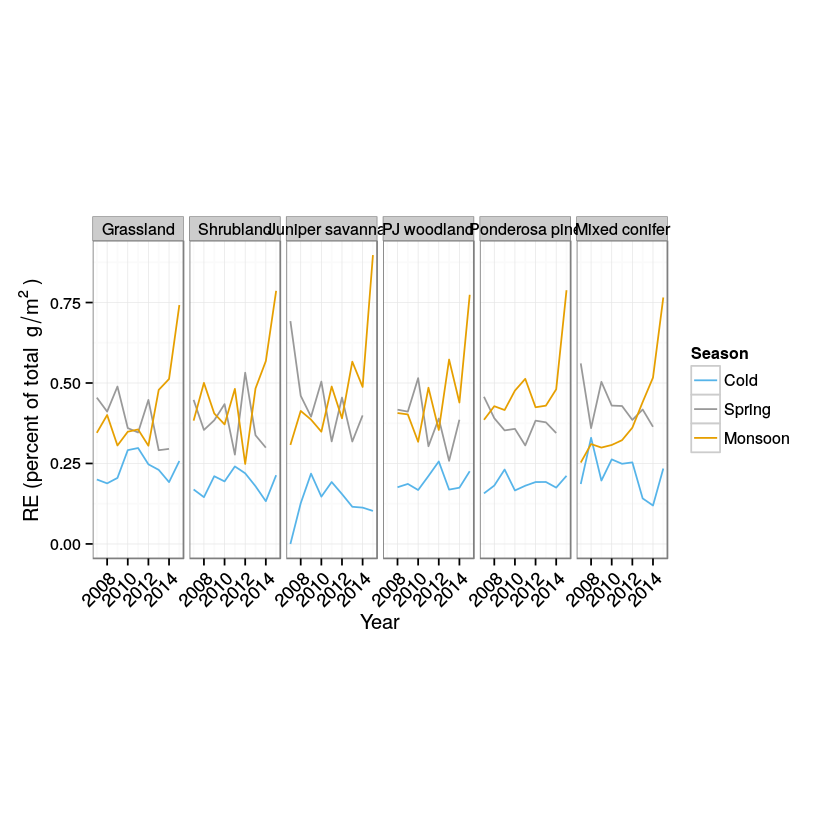

In [14]:
# Calculate seasonal RE as a percentage for the year
RE.pct <- ddply(RE.m, .(variable, year_w), summarise, season=season, pct = seas_sum/sum(seas_sum, na.rm = T))
print(RE.pct[1:10,])

RE_seas_pct_yr <- ggplot(RE.pct, aes(x=year_w, y=pct, color=factor(season))) +
    geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('RE (percent of total '~ g/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

RE_seas_pct_yr

In [ ]:
printfigs(RE_seas_pct_yr, 'RE_seaspct_yr.pdf', outpath, 9, 4)

## Cumulative ET by year (total and percent)

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0.522 0.296 0.268 0.371 1.461 ...
 $ Shrubland       : num  0.55 0.487 0.497 0.51 1.217 ...
 $ Juniper savannah: num  0.836 0.923 0.91 0.829 0.798 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  2.43 3.42 2.45 1.78 2.83 ...
 $ Mixed conifer   : num  1.16 2.059 1.002 2.018 0.966 ...


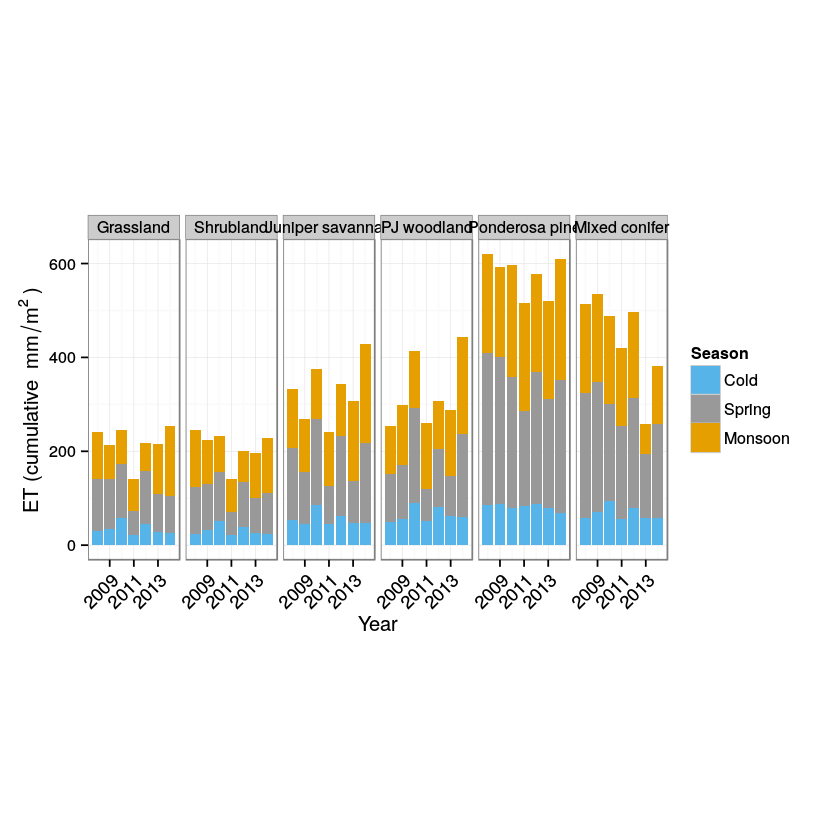

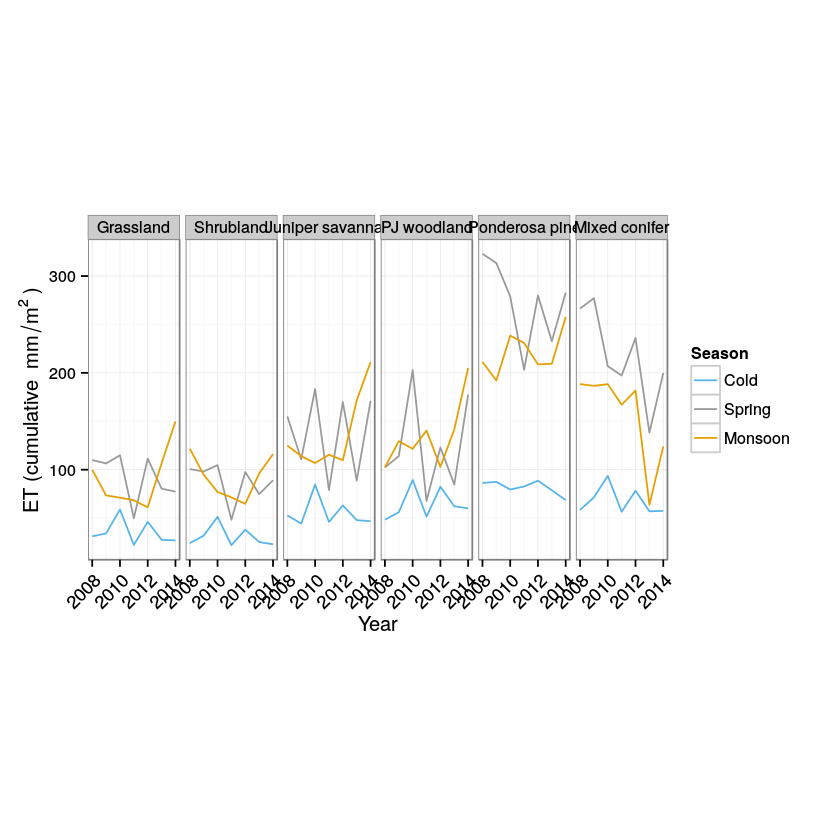

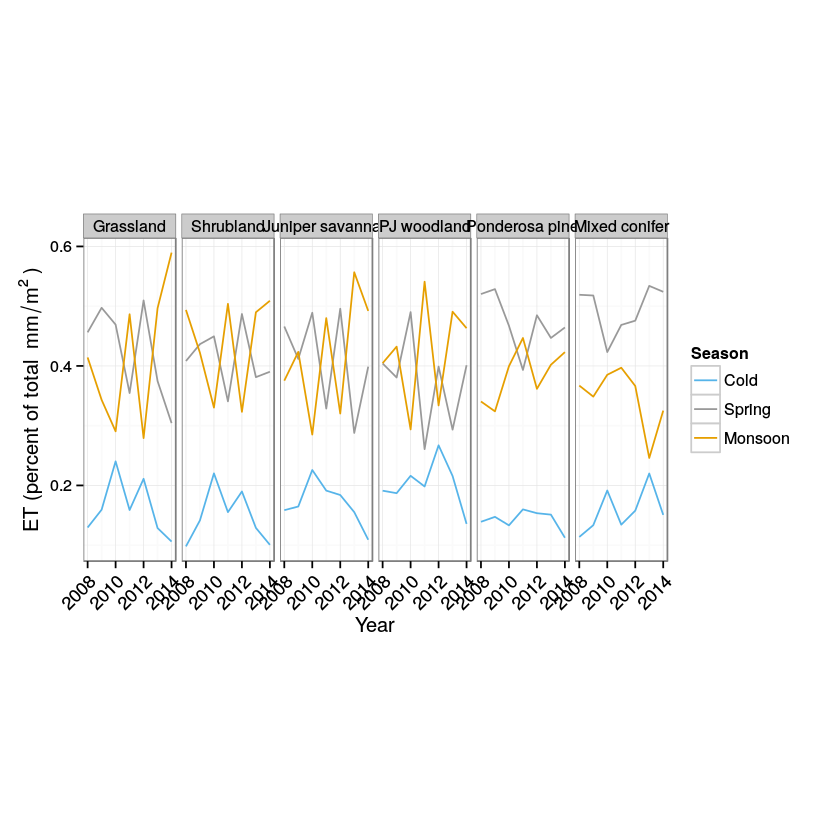

In [48]:
ET.m <- melt(clean_rename(ET_daily), id.vars=c('season', 'year_w'))
ET.m <- ddply(ET.m, .(variable, season, year_w), summarise, seas_sum = sum(value, na.rm = T))

ET_seas_by_yr <- ggplot(ET.m, aes(x=year_w, y=seas_sum, fill=factor(season))) +
  geom_bar(stat='identity') + facet_wrap(~variable, nrow=1) + 
  xlab('Year') + ylab(bquote('ET (cumulative '~ mm/m^2 ~')')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

ET_seas_by_yr

ET_seas_by_yr2 <- ggplot(ET.m, aes(x=year_w, y=seas_sum, color=factor(season))) +
  geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
  xlab('Year') + ylab(bquote('ET (cumulative '~ mm/m^2 ~')')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

ET_seas_by_yr2

# Calculate seasonal ET as a percentage for the year
ET.pct <- ddply(ET.m, .(variable, year_w), summarise, season=season, pct = seas_sum/sum(seas_sum, na.rm = T))
#print(ET.pct[1:10,])

ET_seas_pct_yr <- ggplot(ET.pct, aes(x=year_w, y=pct, color=factor(season))) +
    geom_line(stat='identity') + facet_wrap(~variable, nrow=1) + 
    xlab('Year') + ylab(bquote('ET (percent of total '~ mm/m^2 ~')')) +
    theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
    scale_color_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
    theme(aspect.ratio=3.5)

ET_seas_pct_yr

In [ ]:
printfigs(ET_seas_by_yr, 'ET_seas_by_yr.pdf', outpath, 9, 4)
printfigs(ET_seas_by_yr2, 'ET_seas_by_yr2.pdf', outpath, 9, 4)
printfigs(ET_seas_pct_yr, 'ET_seas_pct_yr.pdf', outpath, 9, 4)

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0.1424 0.0887 0.086 0.1031 0.0583 ...
 $ Shrubland       : num  0.577 0.519 0.419 0.448 0.42 ...
 $ Juniper savannah: num  1.81 1.88 1.82 1.63 1.47 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  3.02 5.21 4.56 3.73 2.89 ...
 $ Mixed conifer   : num  1.91 2.88 2.09 2.47 1.8 ...


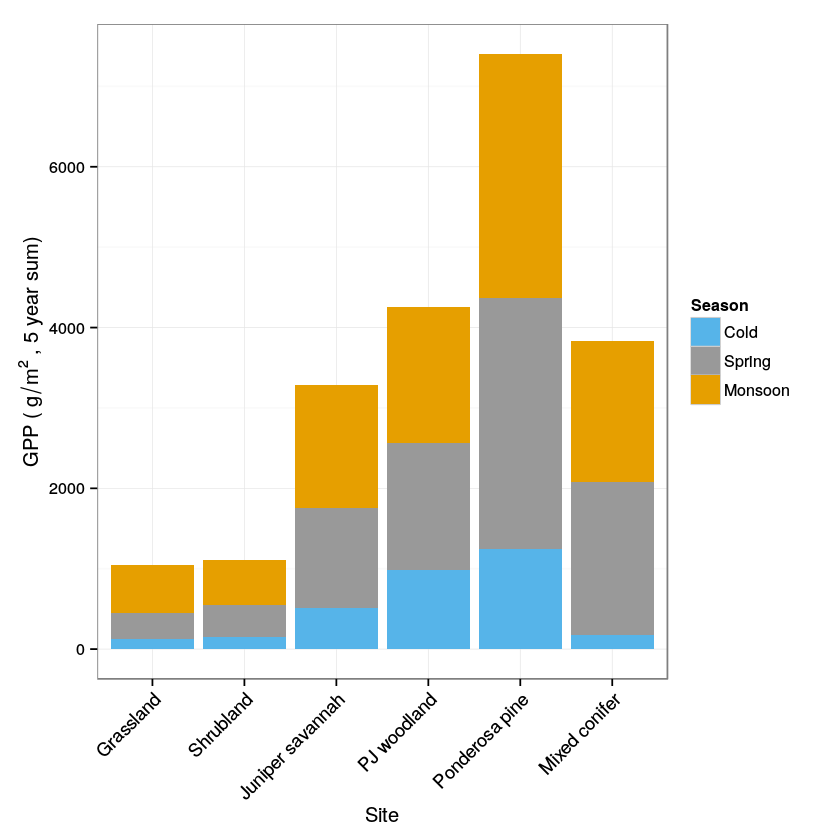

In [49]:
# Look at 5 year cumulative GPP, divided into the 3 seasons
GPP.m <- melt(clean_rename(GPP_daily), id.vars='season')
GPP.m <- subset(GPP.m, subset=(variable != 'year_w'))
GPP.m <- ddply(GPP.m, .(variable, season), summarise, sum = sum(value, na.rm = T))

GPP_seas_multiyr <- ggplot(GPP.m, aes(x=variable, y=sum, fill=factor(season))) +
  geom_bar(stat='identity') + xlab('Site') + 
  ylab(bquote('GPP ('~ g/m^2 ~', 5 year sum)')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
                    name="Season")
GPP_seas_multiyr

'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.492 0.695 0.566 0.451 0.204 ...
 $ Shrubland       : num  0.453 0.439 0.485 0.258 0.201 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  0.245 0.356 0.282 0.661 0.262 ...
 $ Mixed conifer   : num  0.201 0.438 0.398 0.405 0.233 ...


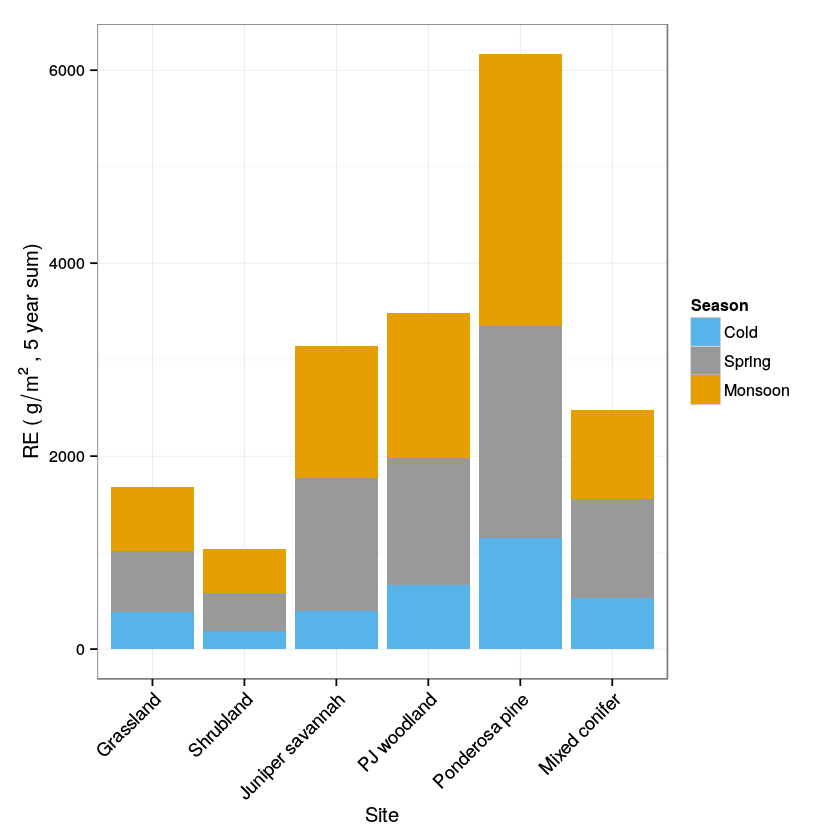

In [17]:
# Look at cumulative RE over a 5 year period, divided into the 3 seasons
RE.m <- melt(clean_rename(RE_daily), id.vars='season')
RE.m <- subset(RE.m, subset=(variable != 'year_w'))
RE.m <- ddply(RE.m, .(variable, season), summarise, sum = sum(value, na.rm = T))

RE_seas_multiyr <- ggplot(RE.m, aes(x=variable, y=sum, fill=factor(season))) +
  geom_bar(stat='identity') + xlab('Site') + 
  ylab(bquote('RE ('~ g/m^2 ~', 5 year sum)')) +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
                    name="Season")
RE_seas_multiyr

'data.frame':	2557 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 3 3 3 3 3 3 3 3 3 3 ...
 $ year_w          : num  2008 2008 2008 2008 2008 ...
 $ Grassland       : num  0 0 0 2.973 0.205 ...
 $ Shrubland       : num  0 0 0 3.403 0.212 ...
 $ Juniper savannah: num  0 0 0 0 0 0 0 0 0 0 ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  0 2.54 5.08 0 0 0 2.54 0 0 0 ...
 $ Mixed conifer   : num  0 2.54 0 2.54 0 ...


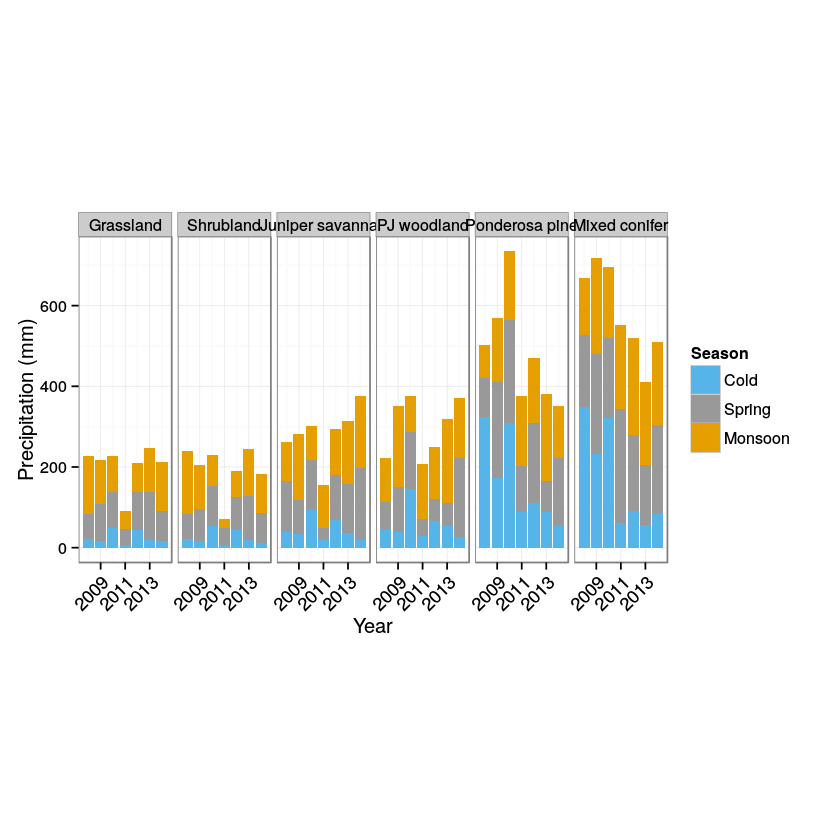

In [50]:
# Look at cumulative gauge Precip over a 6 year period, divided into the 3 seasons
gaugeP.m <- melt(clean_rename(P_gauge_daily), id.vars=c('season', 'year_w'))
#print(P.m)
gaugeP.m <- ddply(gaugeP.m, .(variable, season, year_w), summarise, sum = sum(value, na.rm = TRUE))

P_seas_by_yr <- ggplot(gaugeP.m, aes(x=year_w, y=sum, fill=factor(season))) +
  geom_bar(stat='identity') + facet_wrap(~ variable, nrow=1) +
  xlab('Year') + ylab('Precipitation (mm)') + 
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
  theme(aspect.ratio=3.5)
P_seas_by_yr

ERROR: Error in melt(P_PRISM_daily, id.vars = c("season", "year_w")): object 'P_PRISM_daily' not found


ERROR: Error in empty(.data): object 'prismP.m' not found


ERROR: Error in ggplot(prismP.m, aes(x = year_w, y = sum, fill = factor(season))): object 'prismP.m' not found


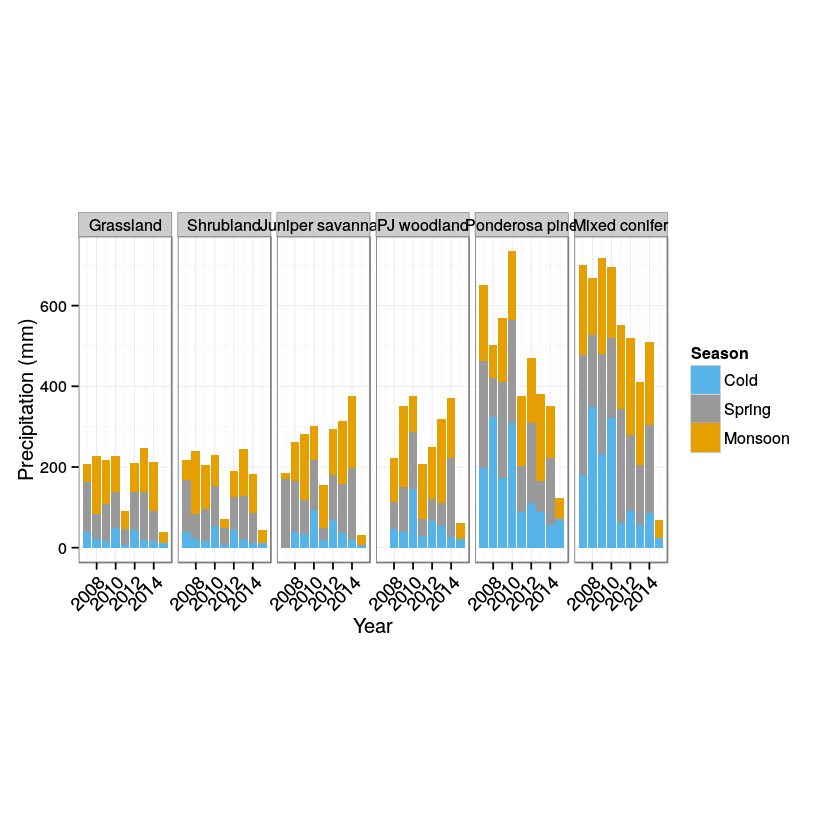

In [19]:
# Look at cumulative PRISM Precip over a 6 year period, divided into the 3 seasons
prismP.m <- melt(P_PRISM_daily, id.vars=c('season', 'year_w'))
prismP.m <- ddply(prismP.m, .(variable, season, year_w), summarise, sum = sum(value, na.rm = T))

P_seas_by_yr <- ggplot(prismP.m, aes(x=year_w, y=sum, fill=factor(season))) +
  geom_bar(stat='identity') + facet_wrap(~ variable, nrow=1) +
  xlab('Year') + ylab('Precipitation (mm)') + 
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), name="Season") +
  theme(aspect.ratio=3.5)
P_seas_by_yr

'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.614 1.024 0 0 1.024 ...
 $ Shrubland       : num  0.106 0 0 0 0.956 0.319 0.106 0 0 0 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  0 2.54 0 10.16 0 ...
 $ Mixed conifer   : num  0 2.54 0 0 2.54 0 0 0 2.54 0 ...


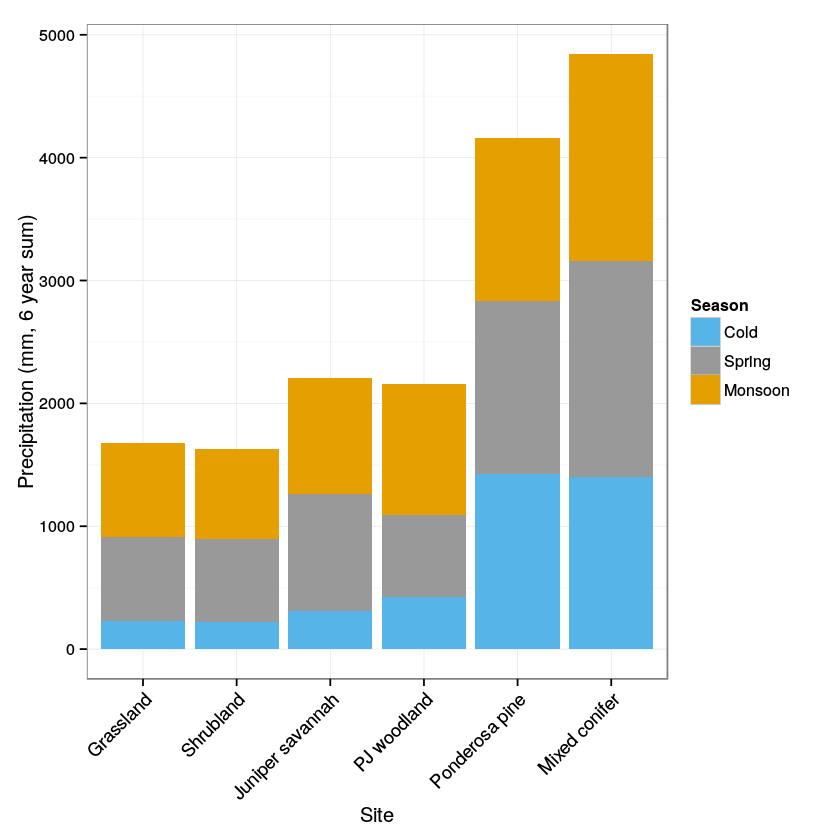

In [20]:
P.m <- melt(clean_rename(P_gauge_daily), id.vars='season')
P.m <- subset(P.m, subset=(variable != 'year_w'))
P.m <- ddply(P.m, .(variable, season), summarise, sum = sum(value, na.rm = T))

P_seas_multiyr <- ggplot(P.m, aes(x=variable, y=sum, fill=factor(season))) +
  geom_bar(stat='identity') + xlab('Site') + ylab('Precipitation (mm, 6 year sum)') +
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
                    name="Season")
P_seas_multiyr

In [ ]:
printfigs(P_seas_multiyr, 'P_seas_multiyr.svg', 7, 6)
printfigs(GPP_seas_by_yr, 'GPP_seas_by_yr.svg', 12, 3)
printfigs(RE_seas_by_yr, 'RE_seas_by_yr.svg', 12, 3)
printfigs(NEE_seas_by_yr, 'NEE_seas_by_yr.svg', 12, 3)
printfigs(P_seas_by_yr, 'P_seas_by_yr.svg', 12, 3)

In [26]:
# Get seasonal FC totals for each season at all sites and yearly total
get_precip_flux_dep <- function(df_daily){
  flux.m <- melt(df_daily, id.vars=c('season', 'year_w'))
  flux_tot <- ddply(flux.m, .(variable, year_w),
                    summarise, year_flux_tot = sum(value, na.rm = T))
  flux_wyr_seas.m <- ddply(flux.m, .(variable, season, year_w),
                           summarise, year_seas_tot = sum(value, na.rm = T))
  
  # subset spring flux
  flux_spring <- subset(flux_wyr_seas.m, subset=(season=='Spring'))
  flux_spring <- rename(flux_spring, c("year_seas_tot"="Spring_flux_tot"))
  flux_spring$season <- NULL
  
  # subset monsoon flux
  flux_monsoon <- subset(flux_wyr_seas.m, subset=(season=='Monsoon'))
  flux_monsoon <- rename(flux_monsoon, c("year_seas_tot"="Monsoon_flux_tot"))
  flux_monsoon$season <- NULL
  
  # Get seasonal Precip totals for each season at all sites
  P.m <- melt(clean_rename(P_gauge_daily), id.vars=c('season', 'year_w'))
  P_wyr_seas.m <- ddply(P.m, .(variable, season, year_w),
                        summarise, P_tot = sum(value, na.rm = T))
  
  # Merge in flux_spring, flux_monsoon, and flux_tot by site/year
  P_dep <- P_wyr_seas.m
  P_dep <- merge(P_dep, flux_tot, by=c('variable', 'year_w'))
  P_dep <- merge(P_dep, flux_spring, by=c('variable', 'year_w'))
  P_dep <- merge(P_dep, flux_monsoon, by=c('variable', 'year_w'))
  
  return(P_dep)
}

In [28]:
NEE_P_dep <- get_precip_flux_dep(clean_rename(FC_daily))
#print(NEE_P_dep)

'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.4824 0.6863 0.5648 0.3478 0.0534 ...
 $ Shrubland       : num  0.4484 0.4386 0.4823 0.1779 0.0769 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  -0.1128 -0.1047 -0.3597 -0.0819 -0.1202 ...
 $ Mixed conifer   : num  0.0773 0.3424 0.1747 0.1108 0.0332 ...
'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.614 1.024 0 0 1.024 ...
 $ Shrubland       : num  0.106 0 0 0 0.956 0.319 0.106 0 0 0 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine

In [29]:
GPP_P_dep <- get_precip_flux_dep(clean_rename(GPP_daily))
#print(GPP_P_dep)

'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.00955 0.00886 0.00147 0.10324 0.15076 ...
 $ Shrubland       : num  0.00447 0 0.00265 0.08032 0.12426 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : num  0.358 0.461 0.642 0.743 0.382 ...
 $ Mixed conifer   : num  0.1232 0.0957 0.2233 0.2939 0.1998 ...
'data.frame':	2922 obs. of  8 variables:
 $ season          : Factor w/ 3 levels "Cold","Spring",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ year_w          : num  2007 2007 2007 2007 2007 ...
 $ Grassland       : num  0.614 1.024 0 0 1.024 ...
 $ Shrubland       : num  0.106 0 0 0 0.956 0.319 0.106 0 0 0 ...
 $ Juniper savannah: num  NA NA NA NA NA NA NA NA NA NA ...
 $ PJ woodland     : num  NA NA NA NA NA NA NA NA NA NA ...
 $ Ponderosa pine  : nu

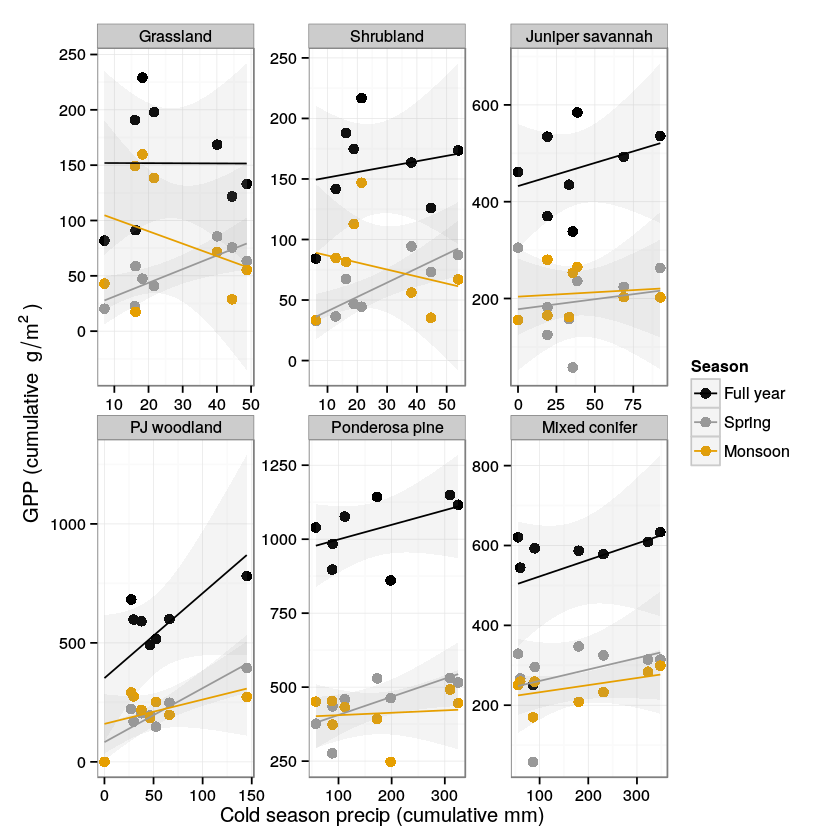

In [30]:
#  Yearly, Spring, and Monsoon fluxes vs cold season precip
subs <- subset(GPP_P_dep, subset=(season=='Cold'))
names(subs)[1]<-"Site"
subs = melt(subs, measure.vars=c("year_flux_tot", "Spring_flux_tot", "Monsoon_flux_tot"))
GPP_on_coldP <- ggplot(subs, aes(x=P_tot, y=value, col=variable)) +
  geom_point(size=3) + stat_smooth(method=lm, alpha = 0.1) +
  facet_wrap(~ Site, scales = 'free') + xlab('Cold season precip (cumulative mm)') + 
  ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
  scale_colour_manual(values=c("black", "#999999", "#E69F00"),
                      labels=c("Full year", "Spring", "Monsoon"),
                      name="Season")
GPP_on_coldP

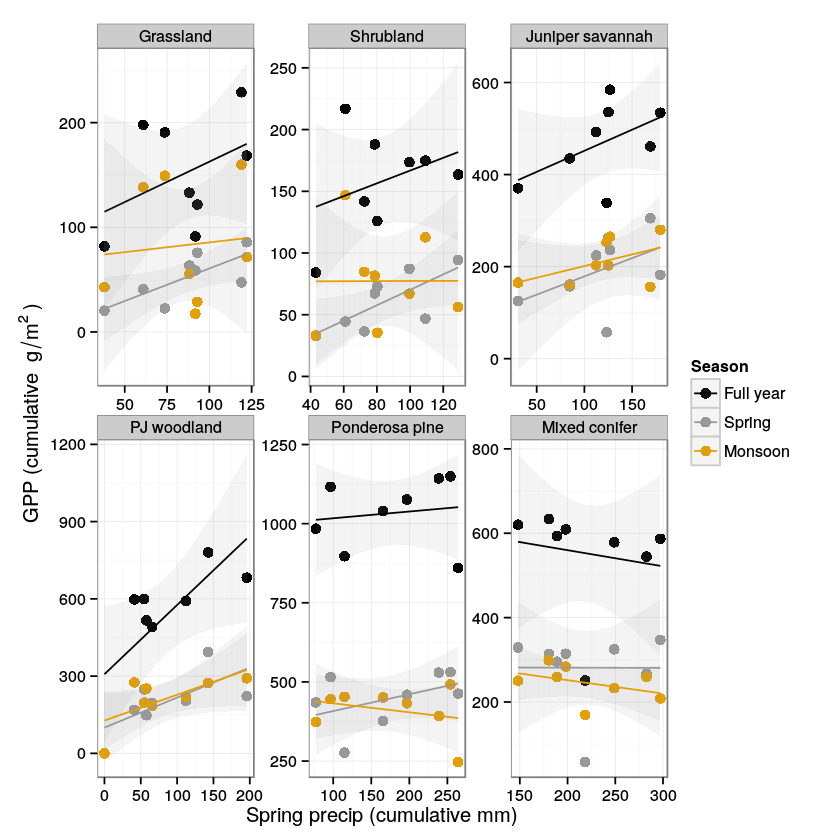

In [31]:
#  Yearly, Spring, and Monsoon fluxes vs spring season precip
subs <- subset(GPP_P_dep, subset=(season=='Spring'))
names(subs)[1]<-"Site"
subs = melt(subs, measure.vars=c("year_flux_tot", "Spring_flux_tot", "Monsoon_flux_tot"))
GPP_on_springP <- ggplot(subs, aes(x=P_tot, y=value, col=variable)) +
  geom_point(size=3) + stat_smooth(method=lm, alpha = 0.1) +
  facet_wrap(~ Site, scales = 'free') + xlab('Spring precip (cumulative mm)') + 
  ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
  scale_colour_manual(values=c("black", "#999999", "#E69F00"),
                      labels=c("Full year", "Spring", "Monsoon"),
                      name="Season")
GPP_on_springP

ERROR: Error in device(paste(basepath, filename, sep = ""), onefile = FALSE, : argument "h" is missing, with no default


ERROR: Error in device(paste(basepath, filename, sep = ""), onefile = FALSE, : argument "h" is missing, with no default


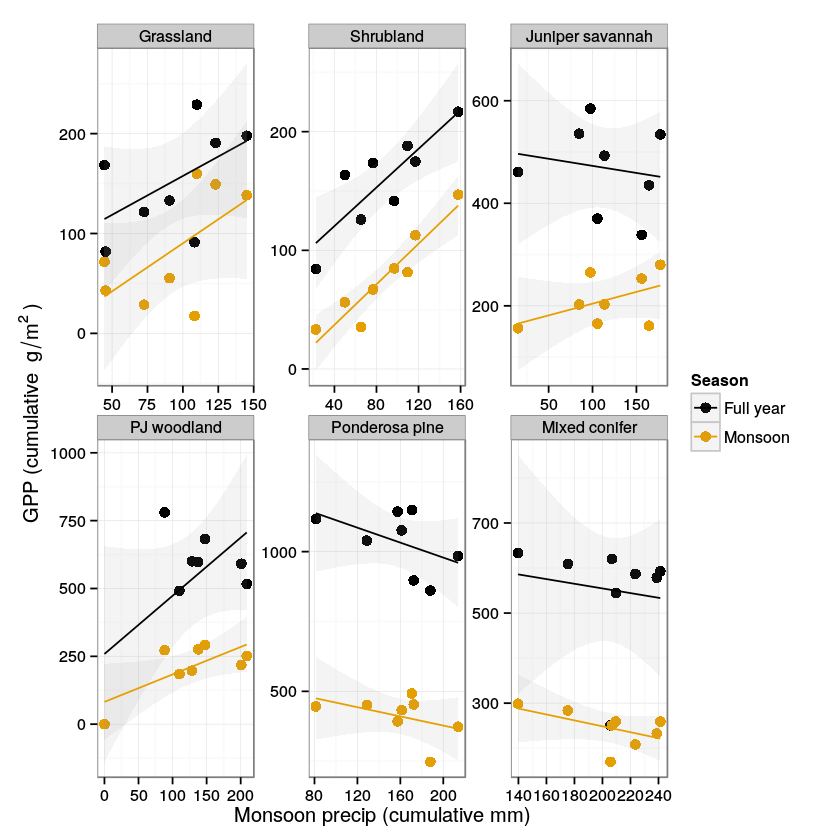

In [32]:
#  Yearly, Spring, and Monsoon fluxes vs monsoon season precip
subs <- subset(GPP_P_dep, subset=(season=='Monsoon'))
names(subs)[1]<-"Site"
subs = melt(subs, measure.vars=c("year_flux_tot", "Monsoon_flux_tot"))
GPP_on_monsoonP <- ggplot(subs, aes(x=P_tot, y=value, col=variable)) +
  geom_point(size=3) + stat_smooth(method=lm, alpha = 0.1) +
  facet_wrap(~ Site, scales = 'free') + xlab('Monsoon precip (cumulative mm)') + 
  ylab(bquote('GPP (cumulative '~ g/m^2 ~')')) +
  scale_colour_manual(values=c("black", "#E69F00"),
                      labels=c("Full year", "Monsoon"),
                      name="Season")

GPP_on_monsoonP
printfigs(GPP_on_monsoonP, 'GPP_on_monsoonP.svg', 8.5, 5)
printfigs(GPP_on_coldP, 'GPP_on_coldP.svg', 8.5, 5)

In [33]:
# On to soil water content
deep <- grep('30_AVG', colnames(VWC_daily), value=T)
shallow <- grep('5_AVG', colnames(VWC_daily), value=T)

VWC_daily['Deep'] <- rowMeans(VWC_daily[deep], na.rm=T)
VWC_daily['Shallow'] <- rowMeans(VWC_daily[shallow], na.rm=T)


# Make a smaller dataset to melt
VWC <- VWC_daily[,c('year_month_mday','year_w','doy_w','season','Deep','Shallow')]
VWC.m <- melt(VWC, id.vars=c('year_month_mday', 'year_w', 'doy_w', 'season'))

VWC_ts <- ggplot(VWC.m, aes(x=as.Date(year_month_mday), y=value, color=variable)) +
  geom_line() + scale_color_manual(name="Soil depth",values=c("blue", "green")) +
  ylab('Volumetric Wate Content') + xlab('Date')

VWC_ts
printfigs(VWC_ts, 'VWC_ts.svg', 10, 2)

ERROR: Error in is.data.frame(x): object 'VWC_daily' not found


ERROR: Error in is.data.frame(x): object 'VWC_daily' not found


ERROR: Error in is.data.frame(x): object 'VWC_daily' not found


ERROR: Error in is.data.frame(x): object 'VWC_daily' not found


ERROR: Error in eval(expr, envir, enclos): object 'VWC_daily' not found


ERROR: Error in melt(VWC, id.vars = c("year_month_mday", "year_w", "doy_w", "season")): object 'VWC' not found


ERROR: Error in ggplot(VWC.m, aes(x = as.Date(year_month_mday), y = value, color = variable)): object 'VWC.m' not found


ERROR: Error in eval(expr, envir, enclos): object 'VWC_ts' not found


ERROR: Error in printfigs(VWC_ts, "VWC_ts.svg", 10, 2): object 'VWC_ts' not found


In [ ]:
VWC.m <- ddply(VWC.m, .(variable, season, year_w),
               summarise, VWC_med = median(value, na.rm = T))

VWC_seas_by_yr <- ggplot(VWC.m, aes(x=year_w, y=VWC_med, fill=factor(season))) +
  geom_bar(stat='identity', position='dodge') + facet_wrap(~ variable, nrow=1) +
  xlab('Year') + ylab('Mean VWC') + 
  theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
  scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
                    name="Season")
VWC_seas_by_yr
#printfigs(VWC_seas_by_yr, 'VWC_seas_by_yr.svg', 6.5, 4)

In [ ]:
GPP_sub <- subset(GPP_P_dep, subset=(year_w > 2008 & variable=='PJ woodland'))
VWC.m <- merge(VWC.m, GPP_sub, by=c('season', 'year_w'))

GPP_vs_VWC <- ggplot(VWC.m, aes(x=VWC_med, y=year_flux_tot, col=factor(season))) +
  geom_point(size=3) + stat_smooth(method=lm, alpha=0.1, fullrange=T) +
  facet_wrap(~variable.x, nrow=1) + xlab('Median VWC') + 
  ylab(bquote('Yearly GPP (cumulative '~ g/m^2 ~')')) +
  scale_colour_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
                      name="Season")
GPP_vs_VWC
printfigs(GPP_vs_VWC, 'GPP_vs_VWC.svg', 6.5, 4)

In [ ]:
# #  Yearly GPP vs total precip in each of 3 seasons
# ggplot(GPP_P_dep, aes(x=P_tot, y=year_flux_tot, col=factor(season))) +
#   geom_point() + facet_wrap(~ variable)
# 
# #  Spring NEE vs total precip in each of 3 seasons
# ggplot(NEE_P_dep, aes(x=P_tot, y=Spring_flux_tot, col=factor(season))) +
#   geom_point() + facet_wrap(~ variable)
# #  Spring GPP vs total precip in each of 3 seasons
# ggplot(GPP_P_dep, aes(x=P_tot, y=Spring_flux_tot, col=factor(season))) +
#   geom_point() + facet_wrap(~ variable)
# 
# #  Monsoon NEE vs total precip in each of 3 seasons
# ggplot(NEE_P_dep, aes(x=P_tot, y=Monsoon_flux_tot, col=factor(season))) +
#   geom_point() + facet_wrap(~ variable)
# #  Monsoon GPP vs total precip in each of 3 seasons
# ggplot(GPP_P_dep, aes(x=P_tot, y=Monsoon_flux_tot, col=factor(season))) +
#   geom_point() + facet_wrap(~ variable)
# 
# + xlab('Site') + ylab('Precipitation (mm, 6 year sum)') +
#   theme(axis.text.x=element_text(angle=45, hjust=1, size=11)) + 
#   scale_fill_manual(values=c("#56B4E9", "#999999", "#E69F00"), 
#                     name="Season")